In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 7.7MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 7.4MB/s 
  Created wheel for wwf: filename=wwf-0.0.10-cp36-none-any.whl size=23155 sha256=450617ab82bc50fc122048e91c75b1283436964ac5b9e2e49861bf8431cc582a
  Stored in directory: /root/.cache/pip/wheels/c7/22/a7/30cb5077503f2c5d1c0af9187090604237d9e075154d833eb5
Successfully built wwf


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-02-05 12:10:24--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-02-05 12:10:24--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc829d57d4fc38ad77fd27815558.dl.dropboxusercontent.com/cd/0/get/BIVkrkuakBmAJ200czkLAodWDiMxlCalre39JY2r3MERTqYkPKiBsxKTri9qihw2NMRf9ZhV0WJn9oPGVBljF3oFq9HlsQrocnmnPP6s2nPqw5uaZVAHLwW3J5eZSUFufXU/file?dl=1# [following]
--2021-02-05 12:10:25--  https://uc829d57d4fc38ad77fd27815558.dl.dropboxusercontent.com/cd/0/get/BIVkrkuakBmAJ200czkLAodWDiMxlCalre39JY2r3MERTqYkPKiBsxKTri9qihw2NMRf9ZhV0WJn9oPGVBljF3oFq9HlsQrocnmnPP6s2nPqw5uaZVAHLwW3J5eZ

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest50d')
]

In [9]:
import timm
timm.list_models('*resnest50d*')

['resnest50d', 'resnest50d_1s4x24d', 'resnest50d_4s2x40d']

In [10]:
learn = timm_learner(dls512, 'resnest50d_4s2x40d',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50_fast_4s2x40d-41d14ed0.pth" to /root/.cache/torch/hub/checkpoints/resnest50_fast_4s2x40d-41d14ed0.pth


SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=9.999999747378752e-06)

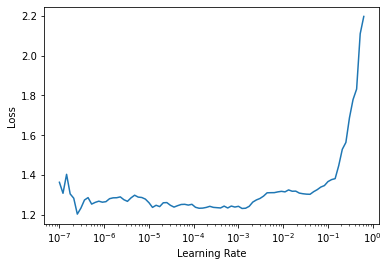

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.349187,1.037179,0.493884,0.483117,0.584906,00:41


Better model found at epoch 0 with valid_loss value: 1.0371792316436768.


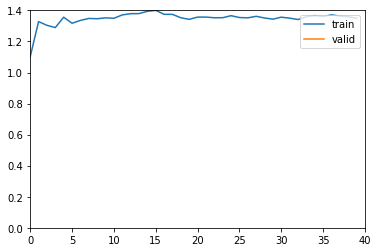

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.282730,0.990883,0.503058,0.489971,0.537736,00:51
1,1.286933,1.009838,0.510703,0.497423,0.606918,00:49
2,1.295974,0.975673,0.507645,0.494595,0.575472,00:49
3,1.279627,0.976976,0.506116,0.493573,0.603774,00:49
4,1.242827,0.922527,0.524465,0.509972,0.562893,00:50
5,1.233168,0.956393,0.513761,0.500000,0.581761,00:50
6,1.202943,0.963536,0.522936,0.508152,0.588050,00:50
7,1.193034,0.931565,0.524465,0.509434,0.594340,00:49


Better model found at epoch 0 with valid_loss value: 0.9908831715583801.


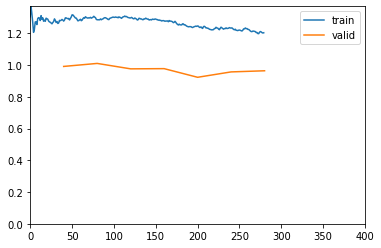

Better model found at epoch 2 with valid_loss value: 0.9756725430488586.
Better model found at epoch 4 with valid_loss value: 0.9225265979766846.
No improvement since epoch 4: early stopping


In [12]:
learn.fine_tune(10,base_lr=1e-5)

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

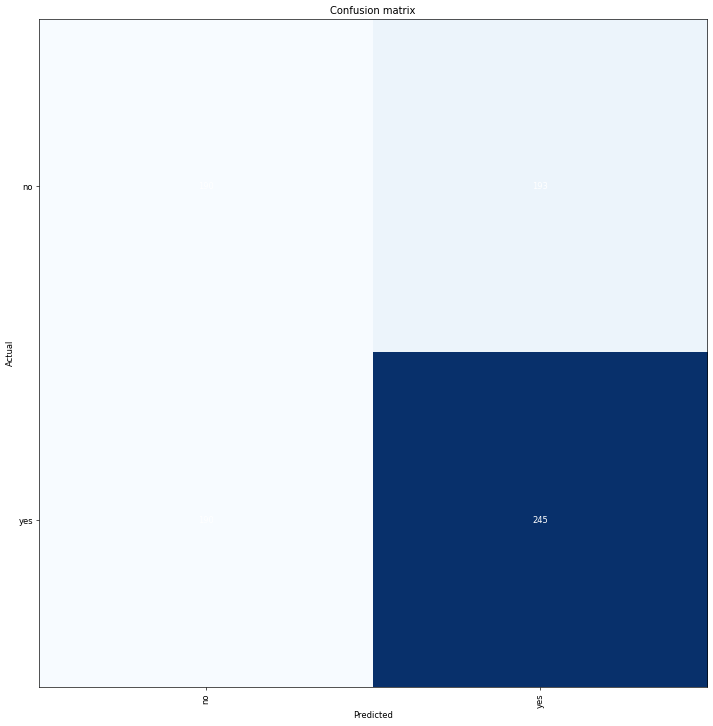

In [15]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [16]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5317848324775696.


(#4) [0.8844178318977356,0.5317848324775696,0.5593607305936074,0.5632183908045977]

In [17]:
learn.export(fname='resnet50.pkl')